# train results

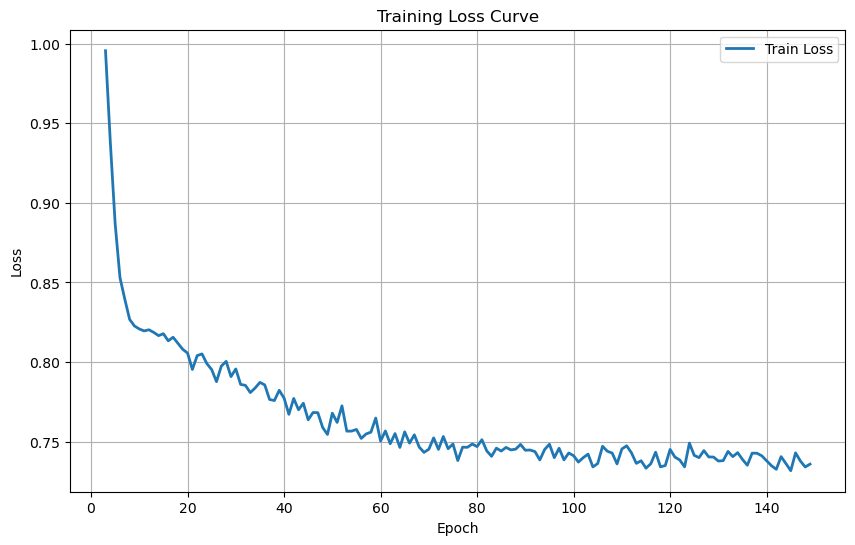

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load the log file
file_path = 'output_old2/log.txt'

# Extract epoch and loss values
data = []
with open(file_path, 'r') as file:
    for line in file:
        entry = json.loads(line)
        data.append((entry['epoch'], entry['train_loss']))

# Create a DataFrame for plotting
df_tot = pd.DataFrame(data, columns=['Epoch', 'Train Loss'])
df = df_tot.iloc[3:]
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

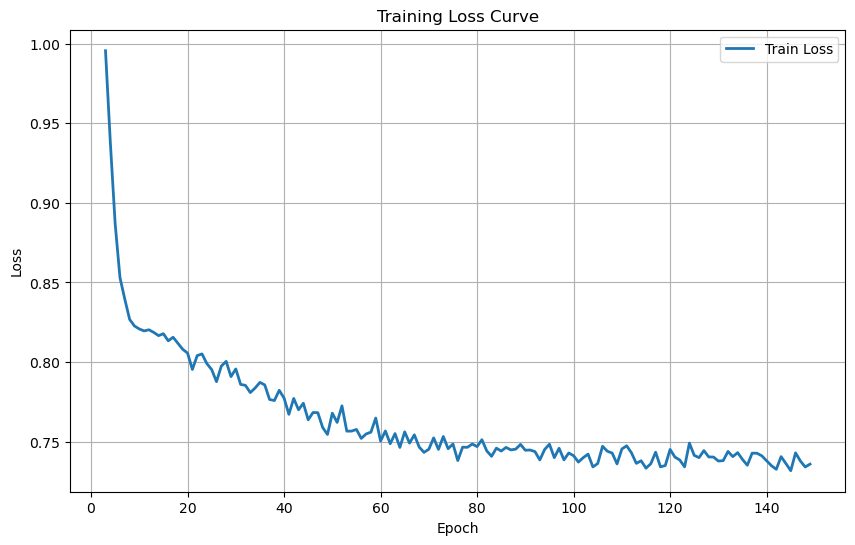

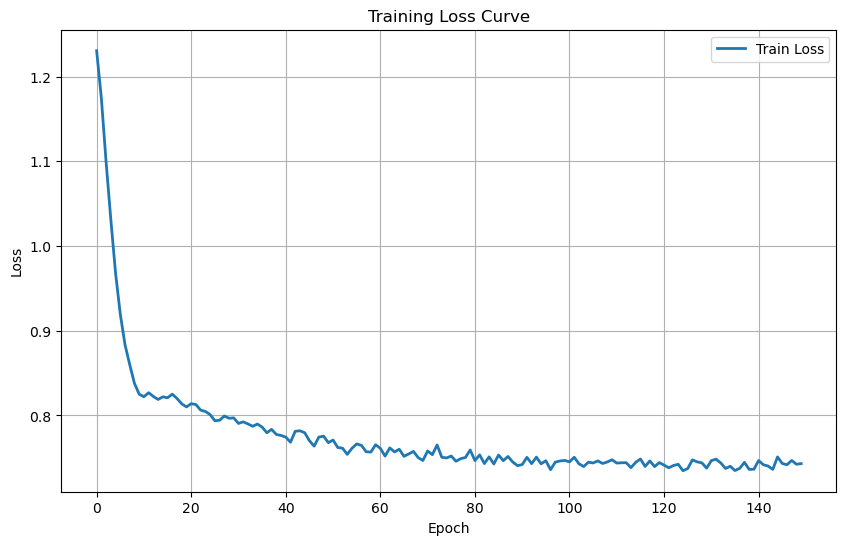

In [5]:
from PIL import Image
import glob

# Trova tutte le immagini PNG nella directory (es. "immagini/*.png")
image_files = sorted(glob.glob("/home/daniele/Documenti/Progetti/VideoMAEv2/sequenced_imgs/freq-6.2_part45/*.png"))  # Ordina per nome
frames = [Image.open(img) for img in image_files]

# Salva la GIF
frames[0].save(
    "animazione.gif",
    save_all=True,
    append_images=frames[1:],  # Aggiungi le altre immagini
    duration=200,  # Durata di ogni frame in millisecondi
    loop=0  # Loop infinito (imposta a 1 per una sola ripetizione)
)
print("GIF salvata come animazione.gif")


GIF salvata come animazione.gif


# Verfica con step di inferenza su un video

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
import os
from PIL import Image
import torch
#import torchvision.transforms as transforms
#import torchvision.transforms.functional as F
import torch.nn.functional as F

from utils import multiple_pretrain_samples_collate
from functools import partial

from dataset import build_pretraining_dataset
from torch.utils.data import DataLoader
from run_mae_pretraining import get_model
from arguments import prepare_args, Args  # NON TOGLIERE: serve a torch.load per caricare il mio modello addestrato

from einops import rearrange

from model_analysis import get_dataloader

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD  = (0.229, 0.224, 0.225)


def visualize_frame(image_tensor, i, t):
    """
    Visualizza un frame da un tensore (batch, canali, frames, H, W).
    """
    image_tensor = image_tensor[i, :, t]  # Prendi il primo batch, primi 3 canali, primo frame
    image_tensor = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia dimensioni per Matplotlib

    plt.imshow(image_tensor)
    plt.axis("off")
    #plt.title("Frame Ricostruito")
    plt.show()

import imageio
def save_animation_gif(frames, filename="output.gif", fps=8):
    """
    Salva la prima clip di `recon` (B,3,T,H,W) come GIF.
    """
    #frames = recon[0]  # (3,T,H,W)
    frames_np = frames.permute(1,2,3,0).cpu().numpy()  # (T,H,W,3)

    # Se i valori sono in [0,1], scaliamo a [0,255]
    frames_uint8 = (frames_np * 255).clip(0,255).astype(np.uint8)

    imageio.mimsave(filename, frames_uint8, fps=fps, loop=100)

/home/daniele/anaconda2024/envs/videomae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = prepare_args()
device = torch.device(args.device)

# Carica i modelli
pretrained_model = get_model(args)
# cambio il path dentro args
#args.init_ckpt = specialized_model_path
#specialized_model = get_model(args)

patch_size = pretrained_model.encoder.patch_embed.patch_size
print("Patch size = %s" % str(patch_size))
args.window_size = (args.num_frames // args.tubelet_size,
                    args.input_size // patch_size[0],
                    args.input_size // patch_size[1])
args.patch_size = patch_size

pretrained_model.to(device)
args.data_path = './test.csv'
data_loader_test = get_dataloader(args)

Creating model: pretrain_videomae_giant_patch14_224


/home/daniele/Documenti/Progetti/VideoMAEv2/models/modeling_pretrain.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_checkpoint, map

Patch size = (14, 14)
Data Aug = (DataAugmentationForVideoMAEv2,
  transform = Compose(
),
  Encoder Masking Generator = Tube Masking: total patches 2048, mask patches 1536,
  Decoder Masking Generator = Running Cell Masking with mask ratio 0.5,
)
Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7fcd7f594670>


## test input dataset

In [3]:
with torch.no_grad():
    images, bool_masked_pos, decode_masked_pos = next(iter(data_loader_test))
    images = images.to(args.device)
    bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    output = pretrained_model(images, bool_masked_pos, decode_masked_pos)

In [4]:
images.shape, output.shape

(torch.Size([20, 3, 16, 224, 224]), torch.Size([20, 1024, 1176]))

In [5]:
len(data_loader_test)

27

In [13]:
#sequences = images.unsqueeze(0)
# Ricostruzione e calcolo delle metriche
with torch.no_grad():
    for batch in data_loader_test:
        images, bool_masked_pos, decode_masked_pos = batch

        # Sposta i dati sul dispositivo
        images = images.to(args.device)
        bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
        decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)

        # Passa i dati al modello
        # Ricostruzioni dei modelli
        output = pretrained_model(images, bool_masked_pos, decode_masked_pos)
        #specialized_reconstructed = specialized_model(images, bool_masked_pos, decode_masked_pos)
        #visualize_frame(images, 0, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


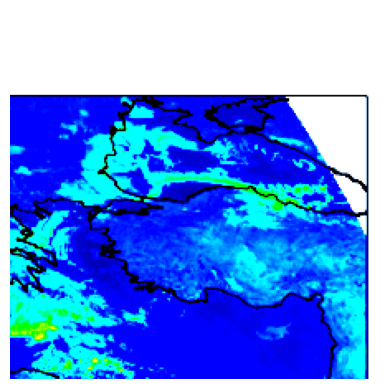

In [11]:
visualize_frame(images, 10, 7)

In [34]:
save_animation_gif(images[3], "my_original.gif", fps=10)

### Maschere

In [11]:
bool_masked_pos.shape, decode_masked_pos.shape, bool_masked_pos.sum(), bool_masked_pos.numel(), decode_masked_pos.sum()

(torch.Size([2, 1568]),
 torch.Size([2, 1568]),
 tensor(2816, device='cuda:0'),
 3136,
 tensor(1568, device='cuda:0'))

In [5]:
3136/1568, 2816/3136

(2.0, 0.8979591836734694)

In [12]:
print("bool_masked_pos =", bool_masked_pos.shape, bool_masked_pos.sum(dim=1))
print("decode_masked_pos =", decode_masked_pos.shape, decode_masked_pos.sum(dim=1))


bool_masked_pos = torch.Size([2, 1568]) tensor([1408, 1408], device='cuda:0')
decode_masked_pos = torch.Size([2, 1568]) tensor([784, 784], device='cuda:0')


### Input e output

In [7]:
print(f"input: {images.shape} - tot size {images.numel()}")
print(f"output: {output.shape} - tot size {output.numel()}")

B, C, T, H, W = images.shape
B, N_patch, patch_dim = output.shape

input: torch.Size([2, 3, 16, 224, 224]) - tot size 4816896
output: torch.Size([2, 784, 1536]) - tot size 2408448


In [8]:
# PATCH DIMENSION

# Supponiamo patch_dim = C * tubelet_size * patch_H * patch_W
tubelet_size = 2
patch_H = 16
patch_W = 16

# verificato
print(patch_dim)
patch_W * patch_H * C * tubelet_size == patch_dim

1536


True

In [9]:
num_p = np.array((H,W)) / np.array((patch_H, patch_W))
print(f" Numero di patch per lato {num_p}")
print(f"Time frames / tubelet size = frame temporali = {T / tubelet_size}")

 Numero di patch per lato [14. 14.]
Time frames / tubelet size = frame temporali = 8.0


In [10]:
num_patches = num_p[0] * num_p[1] * ( T / tubelet_size)
num_patches

np.float64(1568.0)

In [11]:
print(f"abbiamo la metà di maschere nel decoder: {num_patches/2} ")

abbiamo la metà di maschere nel decoder: 784.0 


## ricostruzione

In [3]:
def reconstruct_mae_batch(
    model,                 # il tuo modello pretrain_videomae (già su device)
    images,               # shape (B, 3, T, H, W) su device
    bool_masked_pos,      # shape (B, N), True dove mascherato per l'encoder
    decode_masked_pos,    # shape (B, N), True dove mascherato per il decoder
    patch_size=16,
    tubelet_size=2,
    normlize_target=True,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
):
    """
    Ricostruisce le immagini/video mascherati da un MAE addestrato
    con local patch normalization, restituendo (B, 3, T, H, W) in [0,1].
    """

    device = images.device
    B, C, T, H, W = images.shape
    # Attenzione: T, H, W devono essere multipli di tubelet_size, patch_size

    # -------------------------------------------------
    # 1) Ricalcolo unnorm_images = ( x * std ) + mean
    #    (ovvero rimuovo la normalizzazione globale ImageNet)
    # -------------------------------------------------
    mean_5d = torch.as_tensor(mean, device=device)[None, :, None, None, None]
    std_5d  = torch.as_tensor(std,  device=device)[None, :, None, None, None]
    unnorm_images = images * std_5d + mean_5d  # [0..1] (circa)
    
    # -------------------------------------------------
    # 2) Patchify "alla maniera" del training 
    #    e calcolo mean/std localmente per ogni patch
    # -------------------------------------------------
    # Einops: raggruppiamo T su (t p0), H su (h p1), W su (w p2).
    # Nel tuo train_one_epoch vedo: p0=2, p1=16, p2=16 => tubelet_size=2, patch_size=16
    # -> shape: (B, (t h w), (p0*p1*p2), C)
    images_squeeze = rearrange(
        unnorm_images,
        'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2) c',
        p0=tubelet_size, p1=patch_size, p2=patch_size
    )
    # shape = (B, N, patch_vol, 3), con patch_vol = tubelet_size*patch_size*patch_size

    # Calcoliamo la mean e std locali (patch-wise)
    mu_p = images_squeeze.mean(dim=-2, keepdim=True)            # (B, N, 1, 3)
    sigma_p = (images_squeeze.var(dim=-2, unbiased=True, keepdim=True).sqrt() + 1e-6)

    # Normalizzo i patch localmente => "target style" 
    images_norm = (images_squeeze - mu_p) / sigma_p             # (B, N, patch_vol, 3)

    # Infine reshapo in (B, N, patch_vol*3)
    images_patch_norm = rearrange(images_norm, 'b n p c -> b n (p c)')

    # -------------------------------------------------
    # 3) Forward del modello: produce patch ricostruiti
    #    (solo per i patch mascherati dal decoder)
    # -------------------------------------------------
    # bool_masked_pos e decode_masked_pos => (B, N), boole
    outputs = model(images, bool_masked_pos, decode_masked_pos)
    # outputs.shape => (B, M, patch_vol*3) se M = # patch mascherati dal decoder

    # -------------------------------------------------
    # 4) Inseriamo i patch ricostruiti nelle posizioni mascherate
    #    (nel dominio "patch normalizzato"!)
    # -------------------------------------------------
    recon_patches = images_patch_norm.clone()  # (B, N, patch_vol*3)
    # Sostituisco i patch mascherati
    # "outputs.view(-1,  patch_vol*3)" => shape = (B*M, patch_vol*3) 
    recon_patches[decode_masked_pos] = outputs.view(-1, patch_size*patch_size*tubelet_size*3)

    # -------------------------------------------------
    # 5) Invertiamo la normalizzazione locale patch-wise
    # -------------------------------------------------
    #  Ritorno a shape (B, N, patch_vol, 3)
    recon_patches_4d = rearrange(recon_patches, 'b n (p c) -> b n p c', p=patch_size*patch_size*tubelet_size, c=3)
    #  Ora recon_patches_4d è la ricostruzione normalizzata: x_hat_norm
    
    #  x_hat_raw = x_hat_norm * sigma_p + mu_p
    recon_squeeze = recon_patches_4d * sigma_p + mu_p  # (B, N, patch_vol, 3)

    # -------------------------------------------------
    # 6) "Unpatchify" riassemblando in (B,3,T,H,W)
    # -------------------------------------------------
    recon_unnorm = rearrange(
        recon_squeeze, 
        'b (t h w) (p0 p1 p2) c -> b c (t p0) (h p1) (w p2)',
        t = T // tubelet_size,  # number of temporal patches
        p0 = tubelet_size,
        h = H // patch_size,    # number of patches in H
        p1 = patch_size,
        w = W // patch_size,    # number of patches in W
        p2 = patch_size
    )
    # recon_unnorm ora in [0,1] (circa), shape (B,3,T,H,W)

    # -------------------------------------------------
    # 7) (Opzionale) clamp e ritorna
    # -------------------------------------------------
    recon_unnorm = recon_unnorm.clamp(0.0, 1.0)
    return recon_unnorm

In [36]:
with torch.no_grad():
    images, bool_masked_pos, decode_masked_pos = next(iter(data_loader_test))
    images = images.to(args.device)
    bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
    recon = reconstruct_mae_batch(
                model=pretrained_model,   # deve essere su CUDA
                images=images,
                bool_masked_pos=bool_masked_pos,
                decode_masked_pos=decode_masked_pos,
                patch_size=patch_size[0],
                tubelet_size=2,
                normlize_target=True,
            )
print("Recon shape:", recon.shape)  # (B, 3, T, H, W)

Recon shape: torch.Size([1, 3, 16, 224, 224])


In [39]:
i=0
with torch.no_grad():
    for batch in data_loader_test:
        images, bool_masked_pos, decode_masked_pos = batch

        # Sposta i dati sul dispositivo
        images = images.to(args.device)
        bool_masked_pos = bool_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
        decode_masked_pos = decode_masked_pos.to(args.device, non_blocking=True).flatten(1).to(torch.bool)
        
        recon = reconstruct_mae_batch(
            model=pretrained_model,   # deve essere su CUDA
            images=images,
            bool_masked_pos=bool_masked_pos,
            decode_masked_pos=decode_masked_pos,
            patch_size=patch_size[0],
            tubelet_size=2,
            normlize_target=True,
        )
        #print("Recon shape:", recon.shape)  # (B, 3, T, H, W)
        #show_animation_with_matplotlib(recon, fps=5)
        save_animation_gif(recon[0], f"reconstruction_{i}.gif", fps=7)
        save_animation_gif(images[0], f"my_original_{i}.gif", fps=7)
        i += 1

In [37]:
#show_animation_with_matplotlib(recon, fps=5)
save_animation_gif(recon[0], "reconstruction.gif", fps=7)
save_animation_gif(images[0], "my_original.gif", fps=7)

In [13]:
images_patches = patchify_video(images, patch_size=16, tubelet_size=2)
# shape (B, N=1568, 1536)
print(images_patches.shape)

torch.Size([2, 1568, 1536])


In [14]:
recon_patches = images_patches.clone()  
# di base, recon_patches è identico ai patch originali
# ora andremo a sostituire con i patch ricostruiti dove la maschera è True

In [15]:
# output: (B, M, 1536)
# bool_masked_pos: (B, N) con True per i patch mascherati
# Dunque, se usiamo advanced indexing, qualcosa come:
recon_patches[decode_masked_pos] = output.view(-1, patch_dim)

In [16]:
decode_masked_pos.shape, recon_patches[decode_masked_pos].shape, output.view(-1, 1536).shape

(torch.Size([2, 1568]), torch.Size([1568, 1536]), torch.Size([1568, 1536]))

In [17]:
final_video = unpatchify_video(recon_patches, T, H, W, patch_size=16, tubelet_size=2)

In [23]:
#final_video.shape,
images.shape

torch.Size([2, 3, 16, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


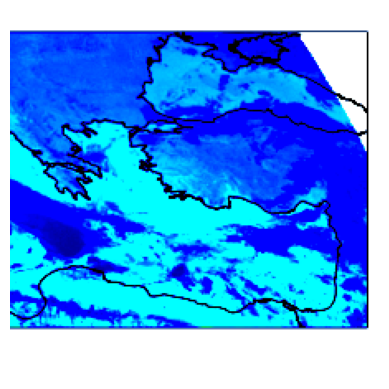

In [12]:
visualize_frame(images, 0, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2978072..2.64].


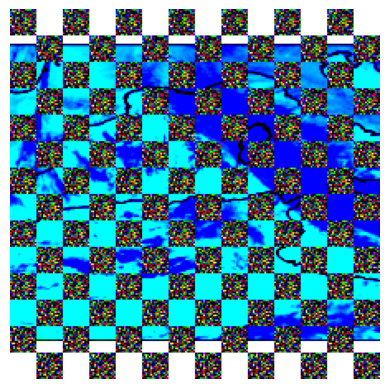

In [40]:
visualize_frame(final_video, 0, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.39635..2.769411].


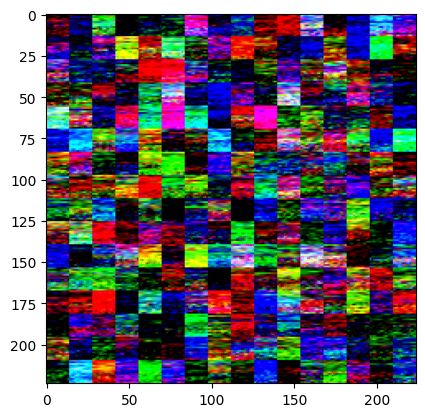

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5353365..2.7349527].


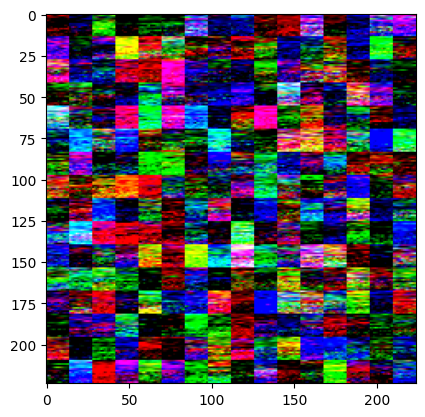

In [34]:
for t in range(2):
    frame = reconstructed_video[0, :, t, :, :] 
    plt.imshow(frame.permute(1,2,0).cpu().numpy())  # se vuoi in [H,W,3]
    plt.show()

In [ ]:
model_path = 'output_old2/checkpoint-149.pth'
load_model(model_path)